<a href="https://colab.research.google.com/github/dksifoua/Object-Detection/blob/master/1%20-%20R-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Oct 14 04:27:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load Dependencies

In [2]:
!pip install tqdm --upgrade

     |████████████████████████████████| 71kB 3.6MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [62]:
import os
import bs4
import cv2
import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.3.0


## Download data

In [5]:
%%time
!mkdir -p ./data
!wget --no-check-certificate \
    https://data.deepai.org/PASCALVOC2007.zip \
    -O ./data/pascal-voc-2007.zip
!unzip -q ./data/pascal-voc-2007.zip -d ./data
!rm -r ./data/pascal-voc-2007.zip

--2020-10-14 03:17:12--  https://data.deepai.org/PASCALVOC2007.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1774851628 (1.7G) [application/x-zip-compressed]
Saving to: ‘./data/pascal-voc-2007.zip’

./data/pascal-voc-2 100%[===================>]   1.65G  20.5MB/s    in 84s     

2020-10-14 03:18:37 (20.1 MB/s) - ‘./data/pascal-voc-2007.zip’ saved [1774851628/1774851628]

CPU times: user 532 ms, sys: 151 ms, total: 682 ms
Wall time: 1min 46s


In [3]:
TRAIN_VAL_IMAGE_DIR = './data/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/'
TRAIN_VAL_ANNOTATION_DIR = './data/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/Annotations/'

## Parse XML image annotations

In [4]:
def parse_xml(path):
    contents = open(path).read()
    soup = bs4.BeautifulSoup(contents, 'html.parser')
    filename = soup.find('filename').string
    objects = []
    for obj in soup.find_all('object'):
        objects.append({
            'name': obj.find('name').string,
            'truncated': obj.find('truncated').string,
            'difficult': obj.find('difficult').string,
            'xmin': int(obj.find('xmin').string),
            'ymin': int(obj.find('ymin').string),
            'xmax': int(obj.find('xmax').string),
            'ymax': int(obj.find('ymax').string)
        }) 
    return filename, objects


def get_annotations(path, description=None):
    annotations = {}
    for fn in tqdm.tqdm(os.listdir(path), desc=description):
        filename, objects = parse_xml(os.path.join(path, fn))
        annotations[filename] = objects
    return annotations


train_val_annotations = get_annotations(path=TRAIN_VAL_ANNOTATION_DIR, description='Load train/val annotations')

Load train/val annotations: 100%|██████████| 5011/5011 [00:14<00:00, 335.05it/s]


In [5]:
LABELS = []
for annotations in train_val_annotations.values():
    for annotation in annotations:
        LABELS.append(annotation['name'])
LABELS = [*set(LABELS)]
print(f'Number of objects: {len(LABELS):,}')
print(LABELS)

Number of objects: 20
['sheep', 'dog', 'sofa', 'tvmonitor', 'motorbike', 'cat', 'boat', 'bottle', 'bicycle', 'pottedplant', 'person', 'chair', 'bus', 'cow', 'diningtable', 'aeroplane', 'horse', 'bird', 'train', 'car']


In [6]:
image_fns = {name: [] for name in LABELS}

for filename in train_val_annotations.keys():
    for name in LABELS:
        for annotation in train_val_annotations[filename]:
            if annotation['name'] == name:
                image_fns[name].append(filename)
n_images = [*map(lambda x: (x[0], len([*set(x[1])])), image_fns.items())] 
sorted(n_images, key=lambda x: x[1]) # We chose to detect only bus

[('sheep', 97),
 ('cow', 146),
 ('boat', 188),
 ('bus', 197),
 ('aeroplane', 240),
 ('motorbike', 249),
 ('bicycle', 255),
 ('bottle', 262),
 ('diningtable', 263),
 ('train', 263),
 ('pottedplant', 273),
 ('tvmonitor', 279),
 ('horse', 294),
 ('bird', 333),
 ('cat', 344),
 ('sofa', 372),
 ('dog', 430),
 ('chair', 572),
 ('car', 761),
 ('person', 2095)]

In [9]:
OBJECT_NAME = 'bus'
TRAIN_VAL_IMAGE_FILENAMES = [
    filename for filename in train_val_annotations if OBJECT_NAME in [*map(lambda annotation: annotation['name'], train_val_annotations[filename])]
]
assert len(TRAIN_VAL_IMAGE_FILENAMES) == 197

## Intersection over union

In [10]:
def compute_intersection_over_union(bndbox1, bndbox2):
    """
    :param dict(int, int, int, int) bndbox1: [x1min, y1min, x1max, y1max]
    :param dict(int, int, int, int) bndbox2: [x2min, y2min, x2max, y2max]
    """
    x1min, y1min, x1max, y1max = bndbox1
    x2min, y2min, x2max, y2max = bndbox2

    w1, w2 = abs(x1min - x1max), abs(x2min - x2max)
    h1, h2 = abs(y1min - y1max), abs(y2min - y2max)

    xmin, xmax = max(x1min, x2min), min(x1max, x2max)
    ymin, ymax = max(y1min, y2min), min(y1max, y2max)
    w, h = max(0, xmax - xmin), max(0, ymax - ymin)

    inter_area = w * h
    union_area = w1 * h1 + w2 * h2 - inter_area

    return inter_area / union_area

## Selective search

CPU times: user 2.95 s, sys: 16.9 ms, total: 2.96 s
Wall time: 2.44 s


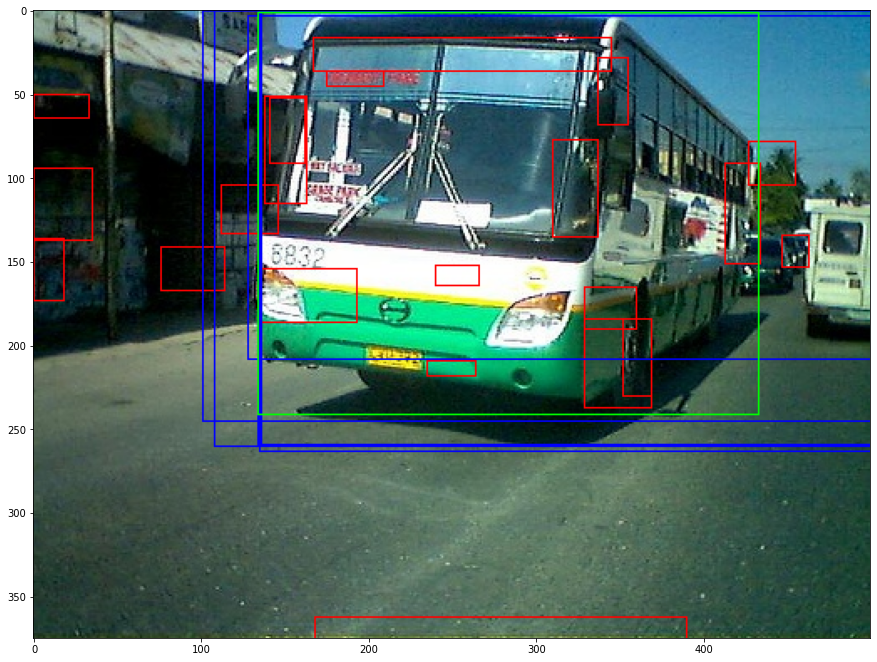

In [15]:
%%time
MIN_ROI_IOU = 0.7
MAX_IOU = 0.05

image_fn = np.random.choice(TRAIN_VAL_IMAGE_FILENAMES)
image = cv2.imread(os.path.join(TRAIN_VAL_IMAGE_DIR, image_fn))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

annotations = train_val_annotations[image_fn]

selective_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
selective_search.setBaseImage(image)
selective_search.switchToSelectiveSearchFast()
rectangles = selective_search.process()

bndboxes = []
for (x, y, w, h) in rectangles:
    # Convert generated bounding boxes from (x, y, w, h) to (xmin, ymin, xmax, ymax)
    bndboxes.append((x, y, x + w, y + h))

plt.figure(figsize=(15, 15))
count_non_roi = 0
for bndbox in bndboxes:
    prop_xmin, prop_ymin, prop_xmax, prop_ymax = bndbox
    is_not_roi = False
    for annotation in annotations:
        name = annotation['name']
        if name != OBJECT_NAME: continue
        xmin, ymin = annotation['xmin'], annotation['ymin']
        xmax, ymax = annotation['xmax'], annotation['ymax']
        cv2.putText(image, name, (xmin, ymin - 3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)
        iou = compute_intersection_over_union(bndbox, (xmin, ymin, xmax, ymax))
        is_not_roi = True if iou < MAX_IOU else False
        if iou > MIN_ROI_IOU:
            cv2.rectangle(image, (prop_xmin, prop_ymin), (prop_xmax, prop_ymax), (0, 0, 255), 1)
    if is_not_roi and count_non_roi <= 20:
        cv2.rectangle(image, (prop_xmin, prop_ymin), (prop_xmax, prop_ymax), (255, 0, 0), 1)
        count_non_roi += 1
plt.imshow(image)

## Create the object detection dataset

In [29]:
def extract_roi(image_dir, image_filenames, image_annotations, image_shape, object_name, odd_dir, min_roi_iou, max_iou, max_positives, max_negatives):
    n_images = {'total +ve images': 0, 'total -ve images': 0}

    for fn in tqdm.tqdm(image_filenames):
        # Load the image 
        image = cv2.imread(os.path.join(image_dir, fn))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        annotations = image_annotations[fn]
        
        # Run selective search
        selective_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        selective_search.setBaseImage(image)
        selective_search.switchToSelectiveSearchFast()
        rectangles = selective_search.process()
        
        # Convert rectangles from [x, y, w, h] to [xmin, ymin, xmax, ymax]
        bndboxes = []
        for (x, y, w, h) in rectangles:
            bndboxes.append((x, y, x + w, y + h))

        
        cnt = {'+ve': 0, '-ve': 0} # Counters for good ROIs (+ve) and bad ROI (-ve) for each image
        for (prop_xmin, prop_ymin, prop_xmax, prop_ymax) in bndboxes: # For each ROI
            for annotation in annotations: # For each annotation
                name = annotation['name']
                
                # Treat only annotation that correspond to object_name [bus]
                if name != object_name:
                    continue
                
                # Get the annotation bounding box
                xmin, ymin, xmax, ymax = annotation['xmin'], annotation['ymin'], annotation['xmax'], annotation['ymax']
                
                # Computer intersection over union
                iou = compute_intersection_over_union((prop_xmin, prop_ymin, prop_xmax, prop_ymax), (xmin, ymin, xmax, ymax))

                roi, roi_path = None, None
                
                # if IOU is greater than a thresold and the +ve counter is less than another thresold
                # then crop the ROI from the image and save it as +ve class
                if iou > min_roi_iou and cnt['+ve'] < max_positives:
                    roi = image[prop_ymin:prop_ymax, prop_xmin:prop_xmax]
                    roi_path = os.path.join(odd_dir, 'positive_{}.jpg'.format(n_images['total +ve images']))
                    cnt['+ve'] += 1
                    n_images['total +ve images'] += 1
                
                # If the ROI does not full overlap (the ROI falls entirely within the ground-truth bounding box)
                # and the IOU is less than a thresold and the -ve counter if less than another thresold then crop
                # the ROI from the image and save it as -ve class
                full_overlap = prop_xmin >= xmin and prop_ymin >= ymin and prop_xmax <= xmax and prop_ymax <= ymax
                if not full_overlap and iou < max_iou and cnt['-ve'] < max_negatives:
                    roi = image[prop_ymin:prop_ymax, prop_xmin:prop_xmax]
                    roi_path = os.path.join(odd_dir, 'negative_{}.jpg'.format(n_images['total -ve images']))
                    cnt['-ve'] += 1
                    n_images['total -ve images'] += 1
                
                # Resize and save the ROI
                if roi is not None and roi_path is not None:
                    roi = cv2.resize(roi, image_shape, interpolation=cv2.INTER_CUBIC)
                    cv2.imwrite(roi_path, roi)
    return n_images

In [60]:
TRAIN_VAL_OBJECT_DETECTION_DATASET_DIR = './data/odd/train_val/'
MAX_POSITIVES, MAX_NEGATIVES = 10, 10
IMAGE_SHAPE = (224, 224)

!rm -rf {TRAIN_VAL_OBJECT_DETECTION_DATASET_DIR}
!mkdir -p {TRAIN_VAL_OBJECT_DETECTION_DATASET_DIR}

n_images = extract_roi(image_dir=TRAIN_VAL_IMAGE_DIR, image_filenames=TRAIN_VAL_IMAGE_FILENAMES,
                       image_annotations=train_val_annotations, image_shape=IMAGE_SHAPE,
                       object_name=OBJECT_NAME, odd_dir=TRAIN_VAL_OBJECT_DETECTION_DATASET_DIR,
                       min_roi_iou=MIN_ROI_IOU, max_iou=MAX_IOU, max_positives=MAX_POSITIVES,
                       max_negatives=MAX_NEGATIVES)
print('Number of positive images: {:,}'.format(n_images['total +ve images']))
print('Number of negative images: {:,}'.format(n_images['total -ve images']))

100%|██████████| 197/197 [08:03<00:00,  2.46s/it]

Number of positive images: 1,381
Number of negative images: 1,970


## Fine-tuning MobileNet V2 model for object detection

The result of the fine-tuning MobileNet will be a classifier that distinguishes between positive and negative images.

***Load images***

In [122]:
data, targets = [], []
for filename in tqdm.tqdm(os.listdir(TRAIN_VAL_OBJECT_DETECTION_DATASET_DIR)):
    target = filename.split('_')[0]
    image = tf.keras.preprocessing.image.load_img(path=os.path.join(TRAIN_VAL_OBJECT_DETECTION_DATASET_DIR, filename), target_size=IMAGE_SHAPE)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    data.append(image); targets.append(target)

100%|██████████| 3351/3351 [00:04<00:00, 786.41it/s]


***Split data***

In [ ]:
%%time
data, targets = np.array(data, dtype='float32'), np.array(targets)

label_binarizer = LabelBinarizer() 
targets = label_binarizer.fit_transform(targets)

X_train, X_valid, y_train, y_valid = train_test_split(data, targets, test_size=0.2, stratify=targets, random_state=781)
print(f'X_train shape: {X_train.shape}')
print(f'X_valid shape: {X_valid.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_valid shape: {y_valid.shape}')

***Build image generator for data augmentation and MobileNet V2 model***

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                                zoom_range=0.15,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.15,
                                                                horizontal_flip=True,
                                                                fill_mode='nearest')
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

def get_mobile_net_v2():
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMAGE_SHAPE, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(1024, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=x)
    return model

***Fit the model***

In [ ]:
LR = 1e-4
N_EPOCHS = 5
BATCH_SIZE = 64

In [ ]:
model = get_mobile_net_v2()
model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.RMSprop(learning_rate=LR), metrics=['accuracy'])
model.summary()

In [ ]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=BATCH_SIZE)

history = model.fit_generator(train_generator, epochs=N_EPOCHS, validation_data=valid_generator)

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(history.history['loss'], label='train')
axes[0].plot(history.history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='train')
axes[1].plot(history.history['val_accuracy'], label='valid')
axes[1].set_title('Accuracy history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Perplexity')
axes[1].grid(True)
axes[1].legend()

plt.show()

***Evaluate the model***

In [ ]:
y_preds = model.predict(X_valid, batch_size=BATCH_SIZE)
y_preds = np.where(y_preds > 0.5, 1, 0)
print(classification_report(y_valid, y_preds, labels=label_binarizer.classes_))

***Serialize the model***

In [ ]:
model.save('./checkpoint/detector.h5', save_format='h5')
with open('./checpoints/label_binarize.pkl', mode='wb') as file:
    file.write(pickle.dumps(label_binarizer))

## Training our R-CNN object detection model